In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('EDA').getOrCreate()

In [4]:
spark.sparkContext.addFile('https://cnecovid.isciii.es/covid19/resources/datos_ccaas.csv')

In [6]:
from pyspark import SparkFiles
df = spark.read.csv(SparkFiles.get('datos_ccaas.csv'), inferSchema=True, header=True)

In [7]:
df.describe().toPandas()

,summary,ccaa_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_otras,num_casos_prueba_desconocida
0,count,6270,6270,6270,6270,6270,6270,6270
1,mean,None,None,256.0031897926635,232.14003189792663,0.740829346092504,22.79122807017544,0.3311004784688995
2,stddev,None,None,589.7976747719568,532.270801024463,4.8733169409799295,120.11687674928866,2.636318102720163
3,min,AN,2020-01-01,0,0,0,0,0
4,max,VC,2020-11-25,6731,6717,96,1863,68


In [8]:
df.printSchema()

root
 |-- ccaa_iso: string (nullable = true)
 |-- fecha: string (nullable = true)
 |-- num_casos: integer (nullable = true)
 |-- num_casos_prueba_pcr: integer (nullable = true)
 |-- num_casos_prueba_test_ac: integer (nullable = true)
 |-- num_casos_prueba_otras: integer (nullable = true)
 |-- num_casos_prueba_desconocida: integer (nullable = true)



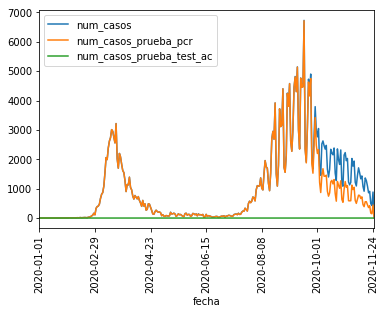

In [18]:
df.filter("ccaa_iso='MD'").sample(fraction=0.9).toPandas().plot(x='fecha',y=['num_casos','num_casos_prueba_pcr','num_casos_prueba_test_ac'],rot=90)

In [19]:
from pyspark.sql.functions import col
data = df.filter(col('ccaa_iso').isin(['MD','CT','CM','CL','AN']))

/home/osboxes/Anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/osboxes/Anaconda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


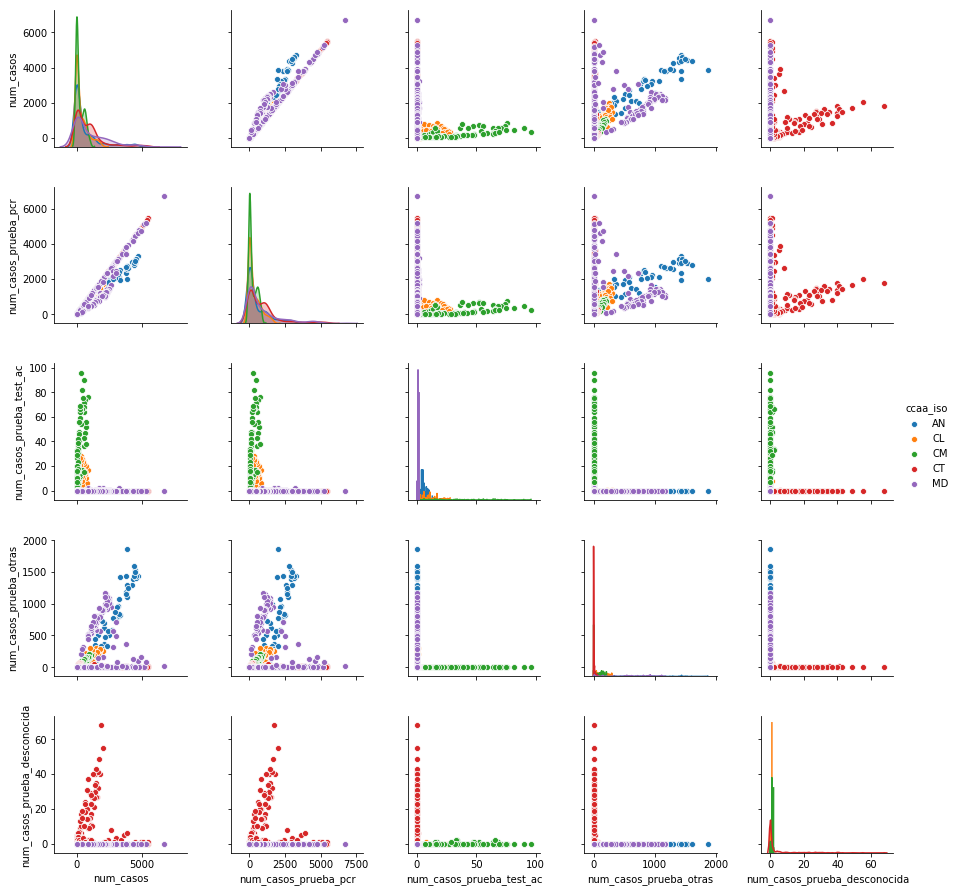

In [22]:
import seaborn as sns
sns.pairplot(data=data.toPandas(),hue='ccaa_iso')

Cada una de las características frente a cada una de las características, y en la diagonal la función de densidad-probabilidad, ya que obviamente los de la diagonal van a estar correlacionados.

In [25]:
data.corr('num_casos', 'num_casos_prueba_test_ac')

-0.07292934626454631

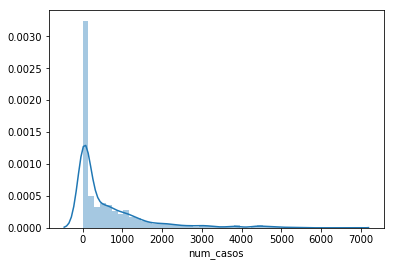

In [31]:
sns.distplot(data.toPandas().num_casos)

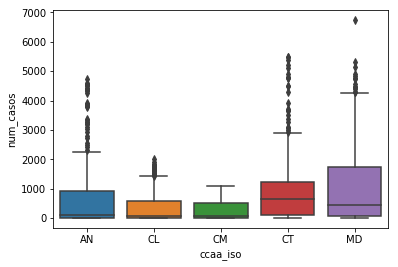

In [34]:
sns.boxplot(data=data.toPandas(),x='ccaa_iso',y='num_casos')

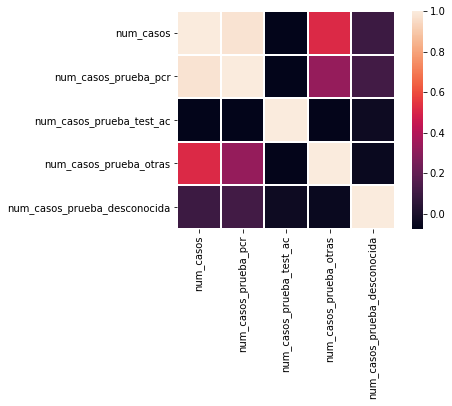

In [39]:
sns.heatmap(data=data.toPandas().corr(),linewidths=1,square=True)

In [41]:
data.columns

['ccaa_iso',
 'fecha',
 'num_casos',
 'num_casos_prueba_pcr',
 'num_casos_prueba_test_ac',
 'num_casos_prueba_otras',
 'num_casos_prueba_desconocida']

In [43]:
from pyspark.ml.feature import VectorAssembler
assembler=VectorAssembler(inputCols=['num_casos_prueba_pcr','num_casos_prueba_test_ac','num_casos_prueba_otras',
                                     'num_casos_prueba_desconocida']
                         ,outputCol='all_features')
final_data = assembler.transform(data)

In [44]:
from pyspark.ml.feature import PCA
pca = PCA(k=2,inputCol='all_features',outputCol='features')
pcaModel=pca.fit(final_data)

In [49]:
pcaModel.explainedVariance
pcaModel.pc.toArray() #ver matriz de correlación, coeficientes menores, más importantes

array([[-9.96394498e-01, -8.48353605e-02],
       [ 7.61597852e-04, -2.02545719e-03],
       [-8.48354609e-02,  9.96390587e-01],
       [-6.07332435e-04, -2.15826754e-03]])

In [50]:
output=pcaModel.transform(final_data)
output.toPandas()

,ccaa_iso,fecha,num_casos,num_casos_prueba_pcr,num_casos_prueba_test_ac,num_casos_prueba_otras,num_casos_prueba_desconocida,all_features,features
0,AN,2020-01-01,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0)","[0.0, 0.0]"
1,CL,2020-01-01,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0)","[0.0, 0.0]"
2,CM,2020-01-01,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0)","[0.0, 0.0]"
3,CT,2020-01-01,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0)","[0.0, 0.0]"
4,MD,2020-01-01,1,1,0,0,0,"(1.0, 0.0, 0.0, 0.0)","[-0.9963944980222277, -0.08483536051194655]"
5,AN,2020-01-02,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0)","[0.0, 0.0]"
6,CL,2020-01-02,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0)","[0.0, 0.0]"
7,CM,2020-01-02,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0)","[0.0, 0.0]"
8,CT,2020-01-02,2,2,0,0,0,"(2.0, 0.0, 0.0, 0.0)","[-1.9927889960444554, -0.1696707210238931]"
9,MD,2020-01-02,0,0,0,0,0,"(0.0, 0.0, 0.0, 0.0)","[0.0, 0.0]"
